In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
import seaborn as sns

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [24]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [25]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'CRC', 'Crohns disease', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(3153, 38)

In [28]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(3153, 903)

In [29]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Define and Train Model

In [30]:
# random seed here deals with model initialization
MyTrainer = Trainer(model = LM.LogisticRegressionCV(random_state = 42), scale_X = True, use_pca = False)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, metrics.balanced_accuracy_score)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [31]:
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

In [32]:
MyMultiTrainTester.train(MatrixData, y)

Running for split 1 of 5
Running for split 2 of 5
Running for split 3 of 5
Running for split 4 of 5
Running for split 5 of 5


In [33]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.949957,train
1,0.961576,train
2,0.961328,train
3,0.949070,train
4,0.956810,train
0,0.825799,test
1,0.824224,test
2,0.823873,test
3,0.824551,test
4,0.812678,test


<AxesSubplot:xlabel='stage', ylabel='score'>

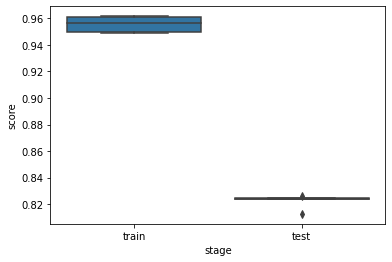

In [34]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

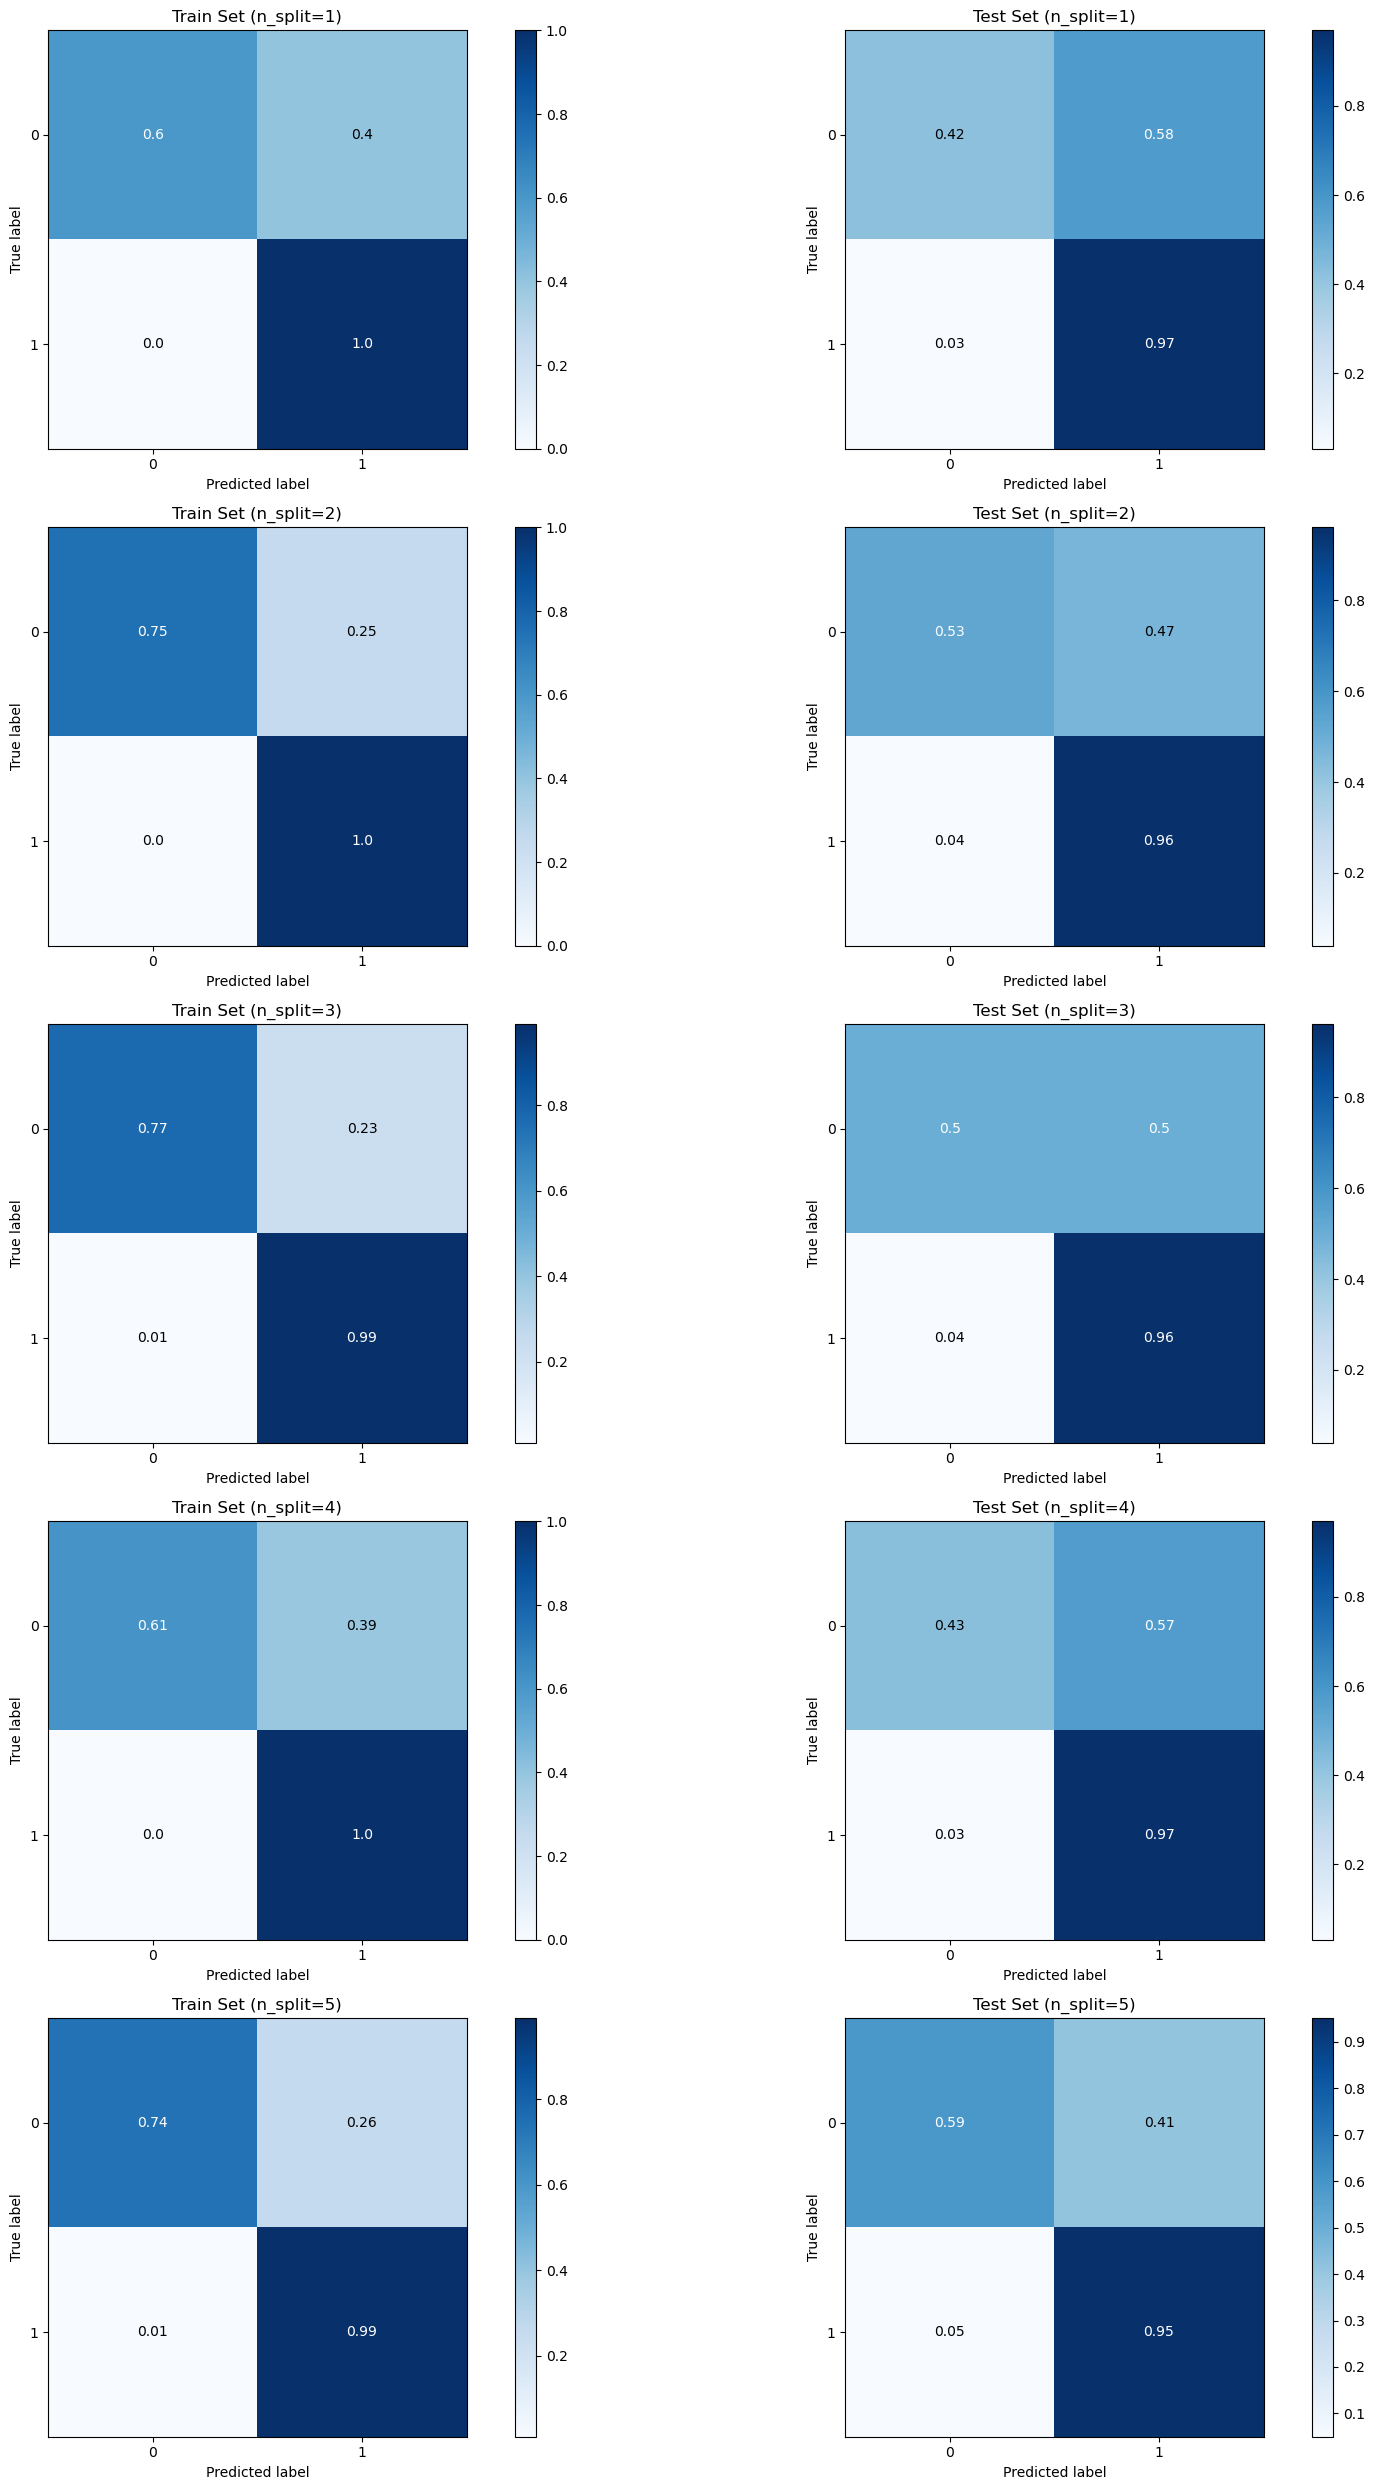

In [35]:
MyMultiTrainTester.plot_confusion(normalize=True)

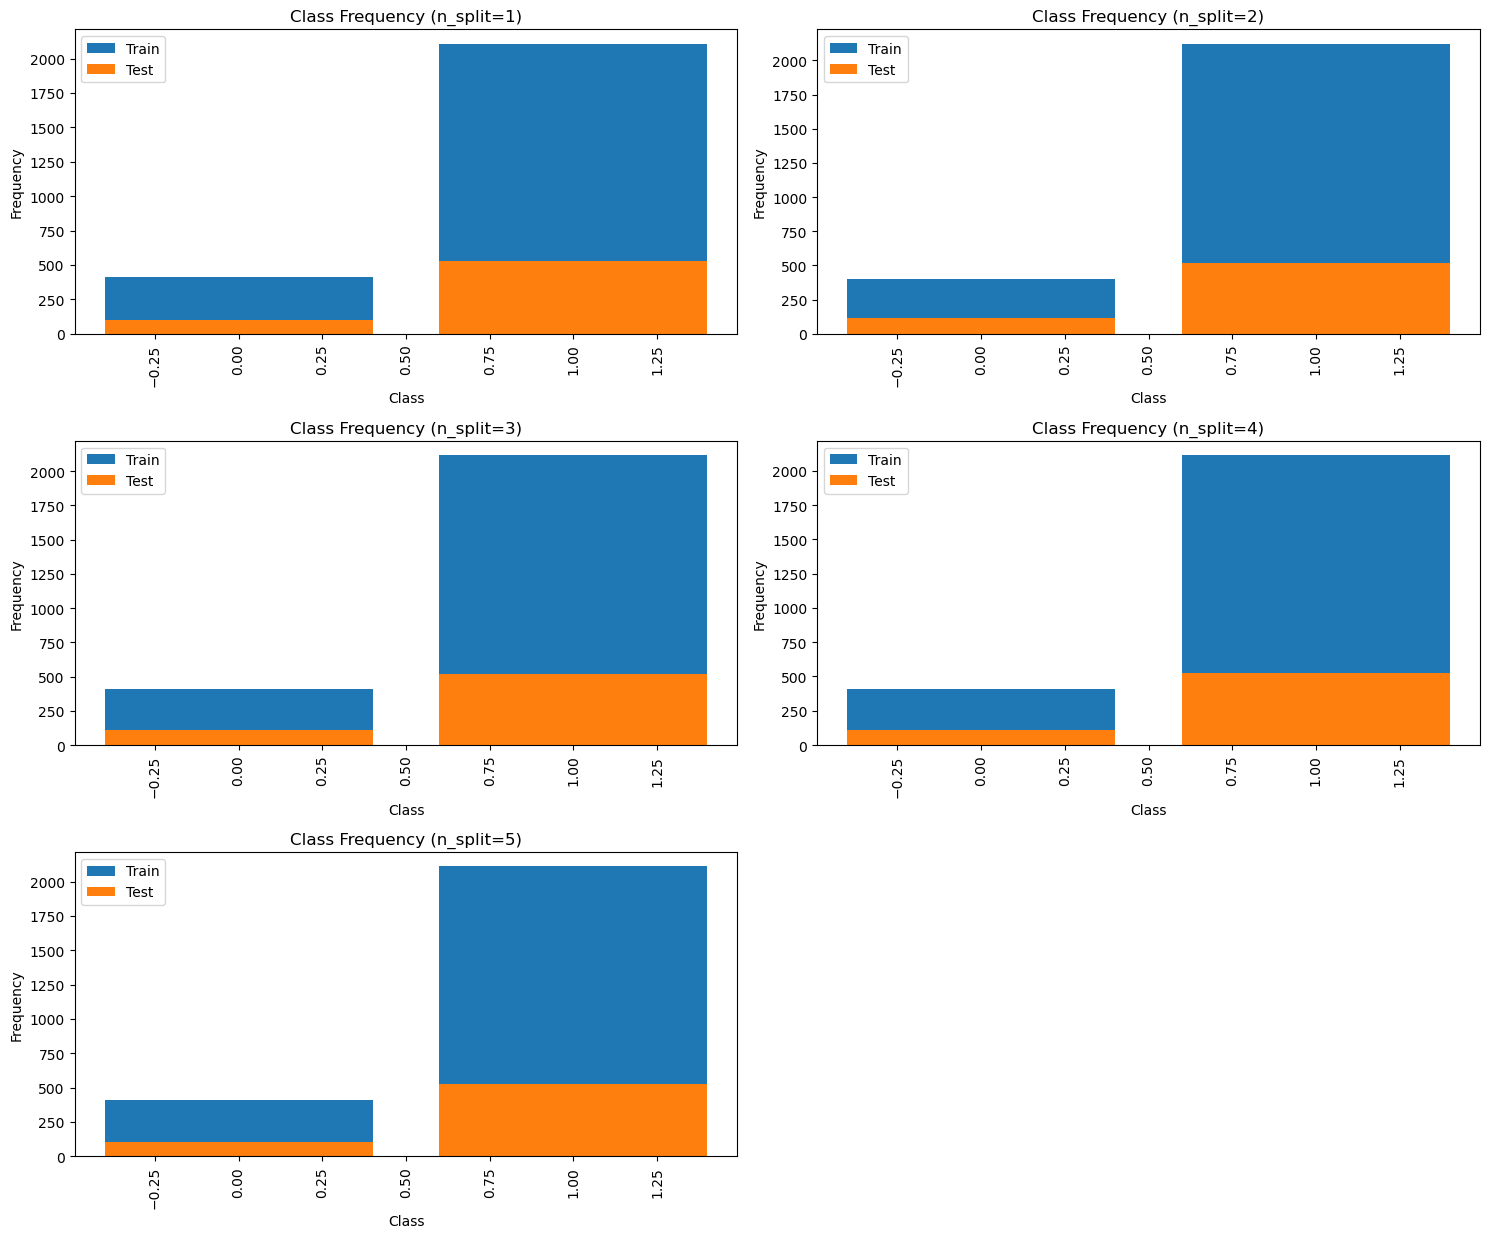

In [36]:
MyMultiTrainTester.plot_class_freq(normalize=True)

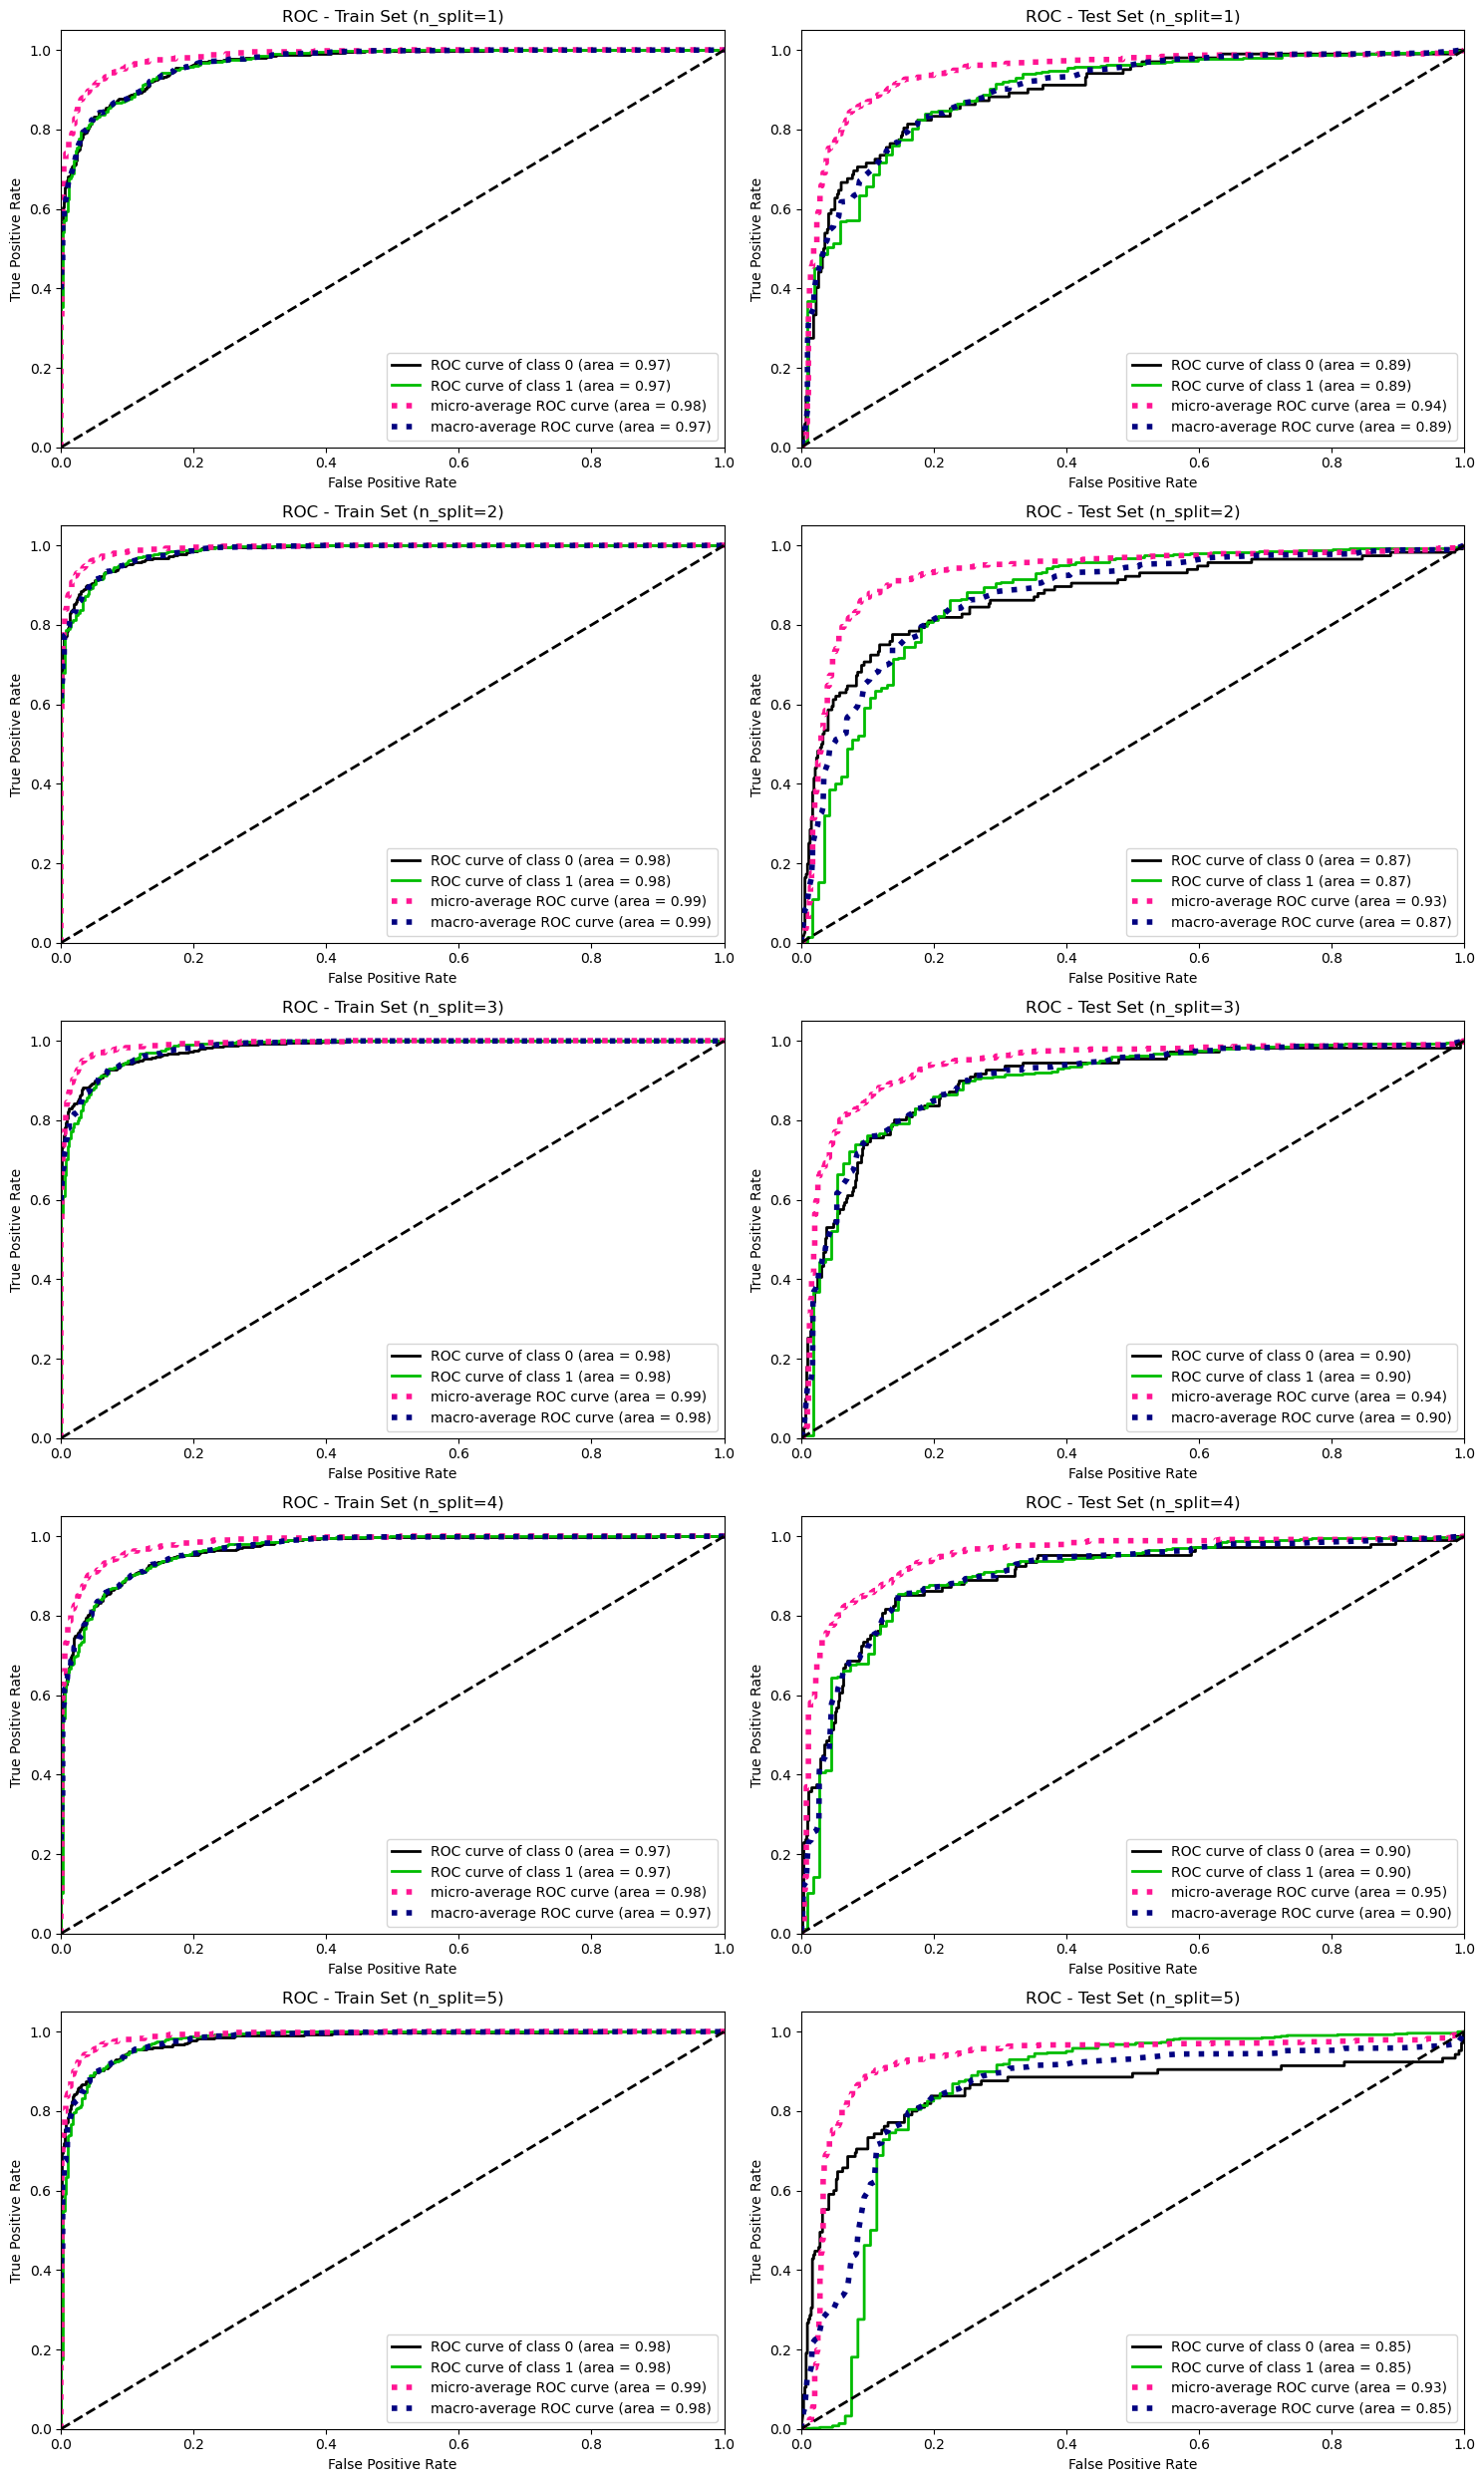

In [37]:
MyMultiTrainTester.plot_roc()

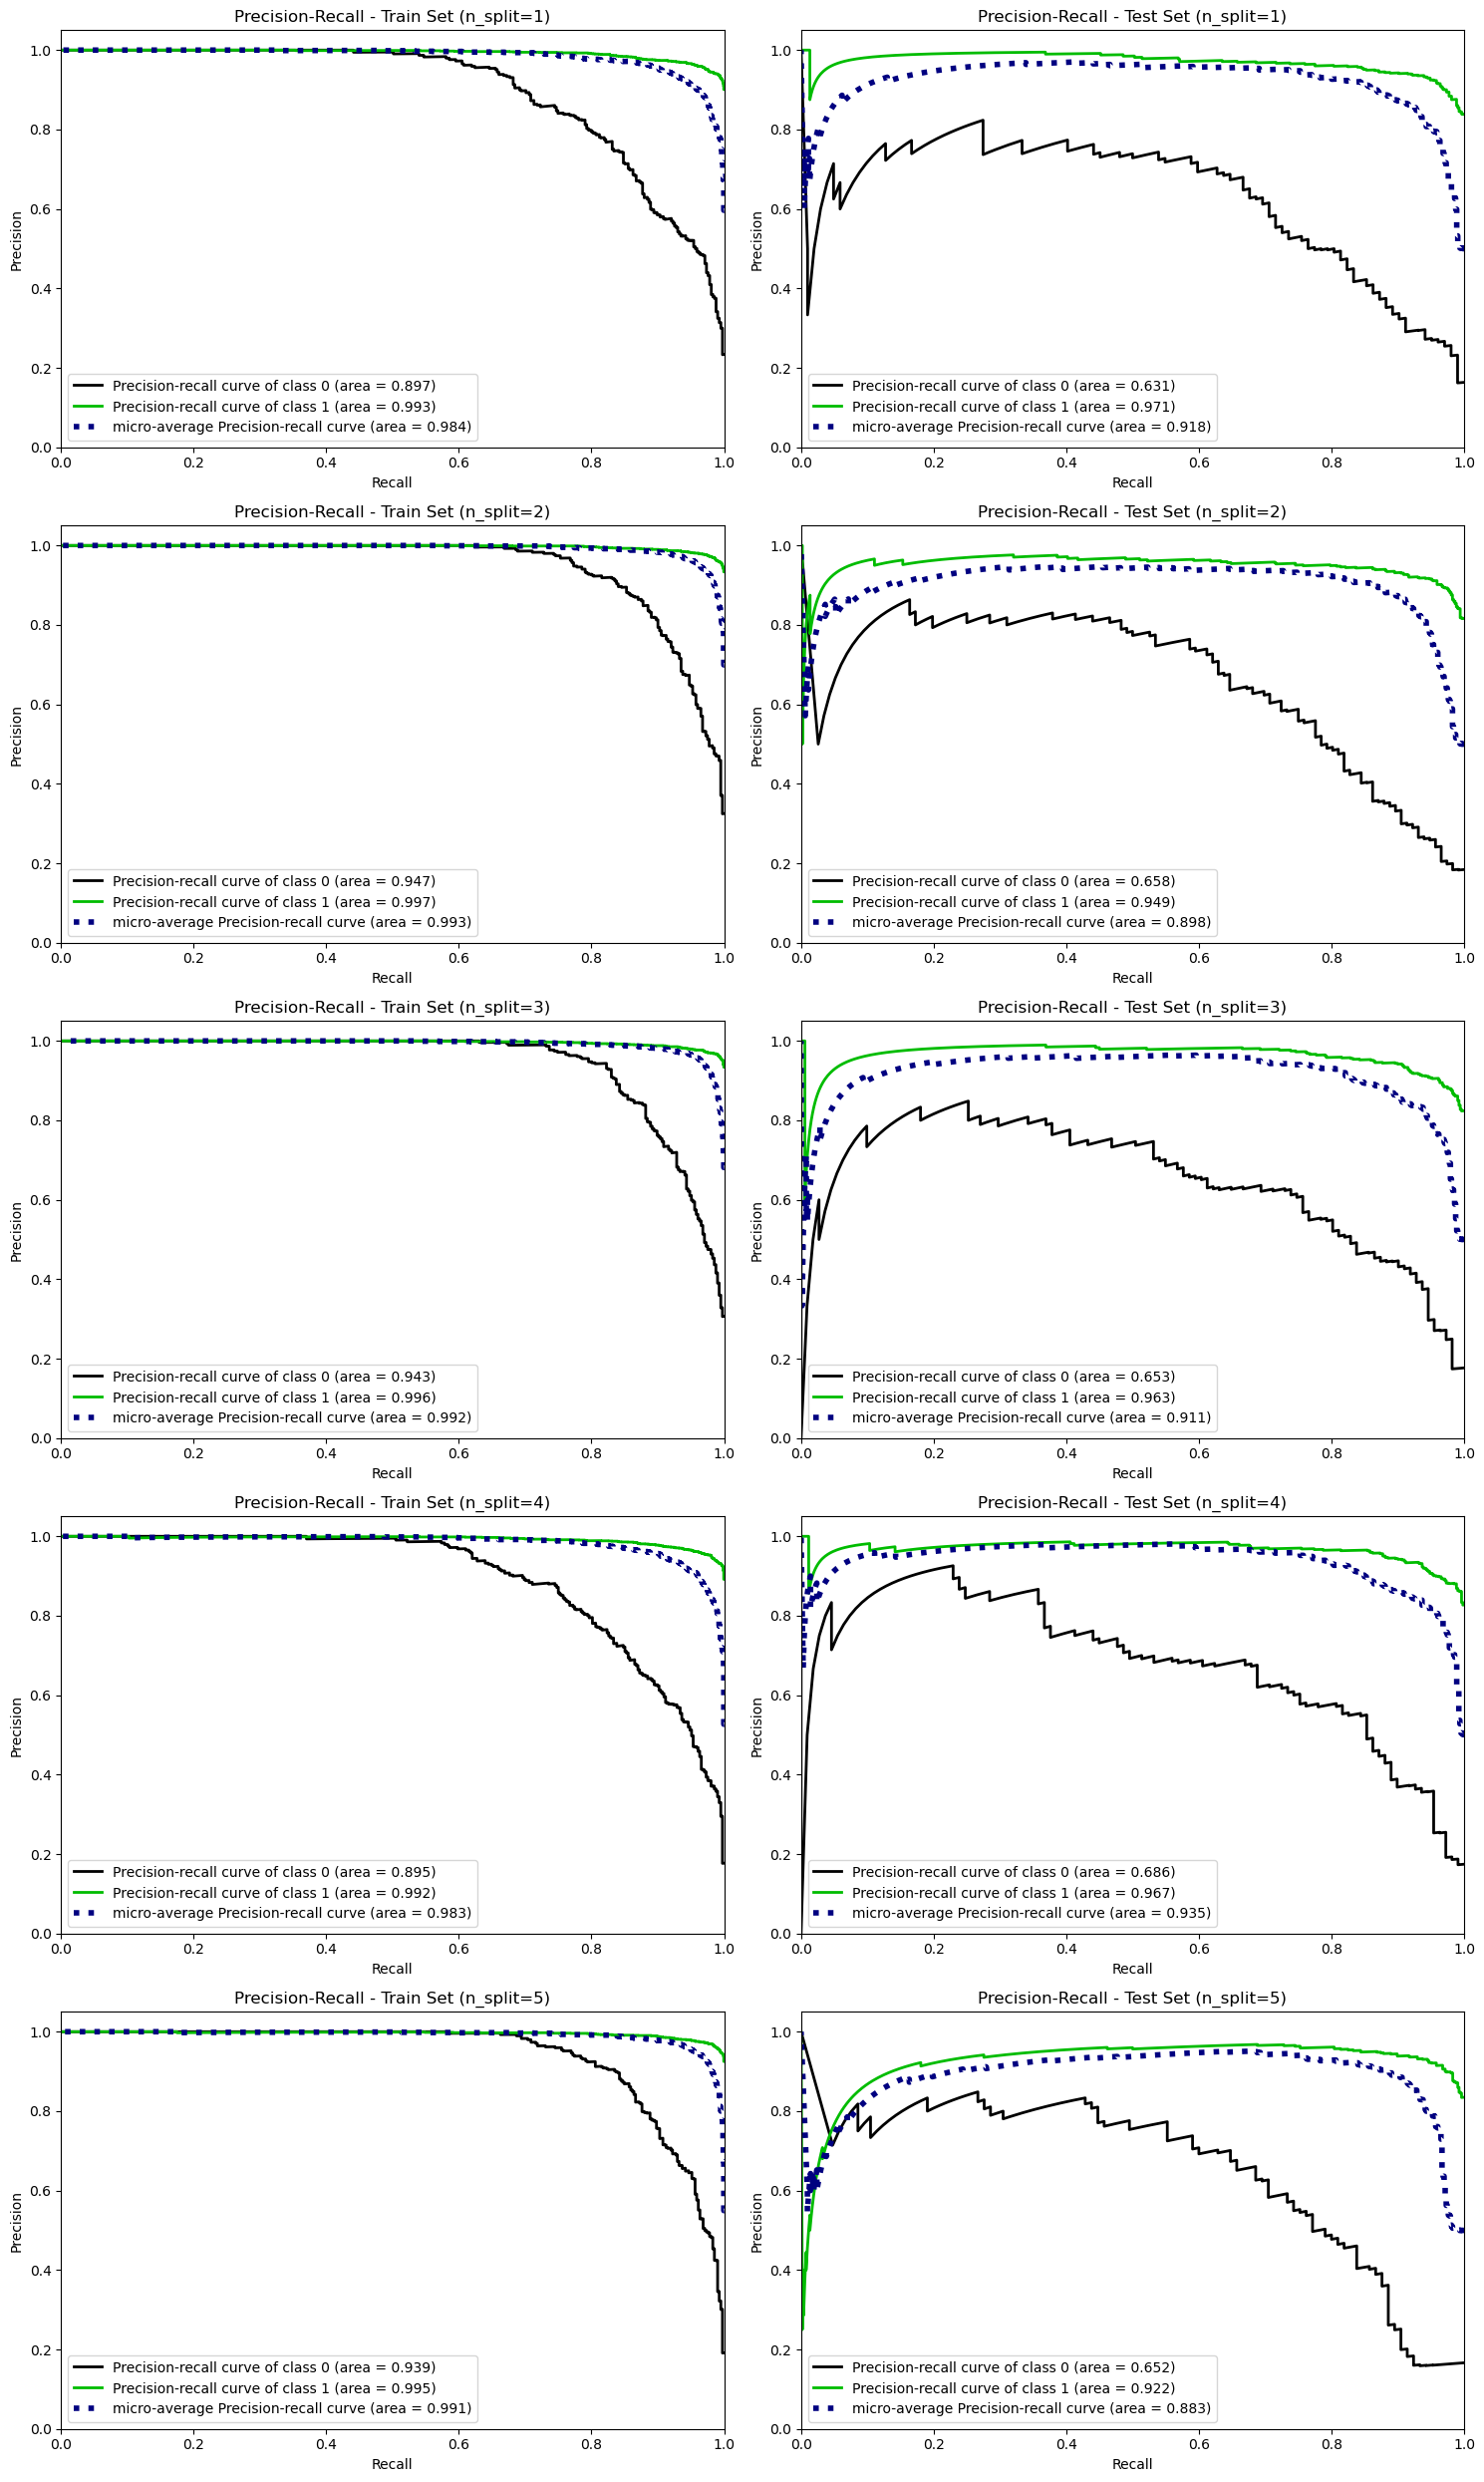

In [38]:
MyMultiTrainTester.plot_precrecall()